In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2024-06-04 02:00:29.235153: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 02:00:29.235242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 02:00:29.355603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


## Pre-processing

In [2]:
raw_df = pd.read_csv('/kaggle/input/human-behavior/raw.csv')

In [3]:
raw_df.drop(columns=raw_df.columns[0], axis=1,  inplace=True)

In [4]:
raw_df.head()

,Subject-id,Activity Code,Timestamp,x,y,z,Device,Sensor
0,1631,A,2019-03-29 15:17:00.859145,-3.231689,0.960129,1.223938,phone,accel
1,1631,A,2019-03-29 15:17:51.213149,-3.688065,2.486359,2.971283,phone,accel
2,1631,A,2019-03-29 15:18:41.567153,-2.923523,8.615723,5.365753,phone,accel
3,1631,A,2019-03-29 15:19:31.921157,0.362640,16.023514,7.035049,phone,accel
4,1631,A,2019-03-29 15:20:22.275160,-5.205841,7.684662,6.512863,phone,accel


In [5]:
raw_df.shape

(15649253, 8)

In [6]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15649253 entries, 0 to 15649252
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Subject-id     int64  
 1   Activity Code  object 
 2   Timestamp      object 
 3   x              float64
 4   y              float64
 5   z              float64
 6   Device         object 
 7   Sensor         object 
dtypes: float64(3), int64(1), object(4)
memory usage: 955.2+ MB


## XGBoost Classifier

In [7]:
# Preprocess data (assuming raw_df is already loaded)
raw_df['x'] = raw_df['x'].astype(float)
raw_df['y'] = raw_df['y'].astype(float)
raw_df['z'] = raw_df['z'].astype(float)

# Convert Timestamp to datetime
raw_df['Timestamp'] = pd.to_datetime(raw_df['Timestamp'])

# Encode the 'Sensor' column
sensor_encoder = OneHotEncoder(sparse_output=False)
sensor_encoded = sensor_encoder.fit_transform(raw_df[['Sensor']])
sensor_encoded_df = pd.DataFrame(sensor_encoded, columns=sensor_encoder.get_feature_names_out(['Sensor']))

# Merge encoded sensor data
raw_df = pd.concat([raw_df.reset_index(drop=True), sensor_encoded_df.reset_index(drop=True)], axis=1)
raw_df.drop(columns=['Sensor'], inplace=True)

# Normalize the accelerometer and gyroscope data separately
scaler_accel = StandardScaler()
scaler_gyro = StandardScaler()

accel_indices = raw_df[raw_df['Sensor_accel'] == 1].index
gyro_indices = raw_df[raw_df['Sensor_gyro'] == 1].index

raw_df.loc[accel_indices, ['x', 'y', 'z']] = scaler_accel.fit_transform(raw_df.loc[accel_indices, ['x', 'y', 'z']])
raw_df.loc[gyro_indices, ['x', 'y', 'z']] = scaler_gyro.fit_transform(raw_df.loc[gyro_indices, ['x', 'y', 'z']])

# Subset for phone only data
phone_data = raw_df[raw_df['Device'] == 'phone']
phone_data = phone_data.drop(columns=['Device'])

# Split data into accelerometer and gyroscope data
accel_data = phone_data[phone_data['Sensor_accel'] == 1].drop(columns=['Sensor_accel', 'Sensor_gyro'])
gyro_data = phone_data[phone_data['Sensor_gyro'] == 1].drop(columns=['Sensor_accel', 'Sensor_gyro'])

# Merge accelerometer and gyroscope data on Timestamp, Subject-id, and Activity Code
merged_data = pd.merge(accel_data, gyro_data, on=['Timestamp', 'Subject-id', 'Activity Code'], suffixes=('_accel', '_gyro'))

merged_data.head()

,Subject-id,Activity Code,Timestamp,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro
0,1631,A,2019-03-29 15:21:12.629164,-0.576347,2.453317,-1.236654,1.334286,-2.184185,0.611700
1,1631,A,2019-03-29 15:22:02.983168,0.542467,2.793823,-0.833212,1.495492,-2.610046,-0.523921
2,1631,A,2019-03-29 15:22:53.337172,-0.279613,1.602022,0.271987,1.078596,0.955817,-0.620082
3,1631,A,2019-03-29 15:23:43.691176,-0.690641,1.926395,-0.951995,2.303744,0.512118,0.311566
4,1631,A,2019-03-29 15:24:34.045180,-0.144795,1.728877,-1.056914,2.009180,0.331311,0.301058


In [8]:
# Encoding the 'Activity Code' column
label_encoder = LabelEncoder()
merged_data['label'] = label_encoder.fit_transform(merged_data['Activity Code'])


In [9]:
# Drop unnecessary columns
data = merged_data.drop(columns=['Subject-id', 'Activity Code', 'Timestamp'])
data.head()

,x_accel,y_accel,z_accel,x_gyro,y_gyro,z_gyro,label
0,-0.576347,2.453317,-1.236654,1.334286,-2.184185,0.611700,0
1,0.542467,2.793823,-0.833212,1.495492,-2.610046,-0.523921,0
2,-0.279613,1.602022,0.271987,1.078596,0.955817,-0.620082,0
3,-0.690641,1.926395,-0.951995,2.303744,0.512118,0.311566,0
4,-0.144795,1.728877,-1.056914,2.009180,0.331311,0.301058,0


In [10]:
data.shape

(2909149, 7)

### Training

In [11]:
from scipy import stats

def get_frames(df, frame_size, hop_size):
    N_FEATURES = 6  # x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size + 1, hop_size):
        x_accel = df['x_accel'].values[i: i + frame_size]
        y_accel = df['y_accel'].values[i: i + frame_size]
        z_accel = df['z_accel'].values[i: i + frame_size]
        x_gyro = df['x_gyro'].values[i: i + frame_size]
        y_gyro = df['y_gyro'].values[i: i + frame_size]
        z_gyro = df['z_gyro'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        segment_labels = df['label'][i: i + frame_size]
        label = segment_labels.mode().values[0] if not segment_labels.mode().empty else segment_labels.values[0]
        
        frames.append([x_accel, y_accel, z_accel, x_gyro, y_gyro, z_gyro])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels


# Set frame size and hop size
frame_size = 80
hop_size = 40

# Create frames and labels
X, y = get_frames(data, frame_size, hop_size)

print(X.shape, y.shape)


(72727, 80, 6) (72727,)


In [12]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import time


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure the input data is in the correct shape
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# Define the XGBoost classifier with the best hyperparameters
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    colsample_bytree=0.9396893641976711,
    gamma=0,
    learning_rate=0.10241823755571676,
    max_depth=6,
    n_estimators=982,
    subsample=0.8545330472743582,
    device='cuda',  
    early_stopping_rounds=10
)

# Measure the time for fitting the model
start_time = time.time()
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
end_time = time.time()

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the time taken for fitting the model
print("Time taken for fitting the model:", end_time - start_time, "seconds")


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [02:04:24] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.855905403547367
Time taken for fitting the model: 114.44398236274719 seconds


In [13]:
import pickle

# Save the trained model to a file
with open('xgb_phone_best_2.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


## Visualizing the model

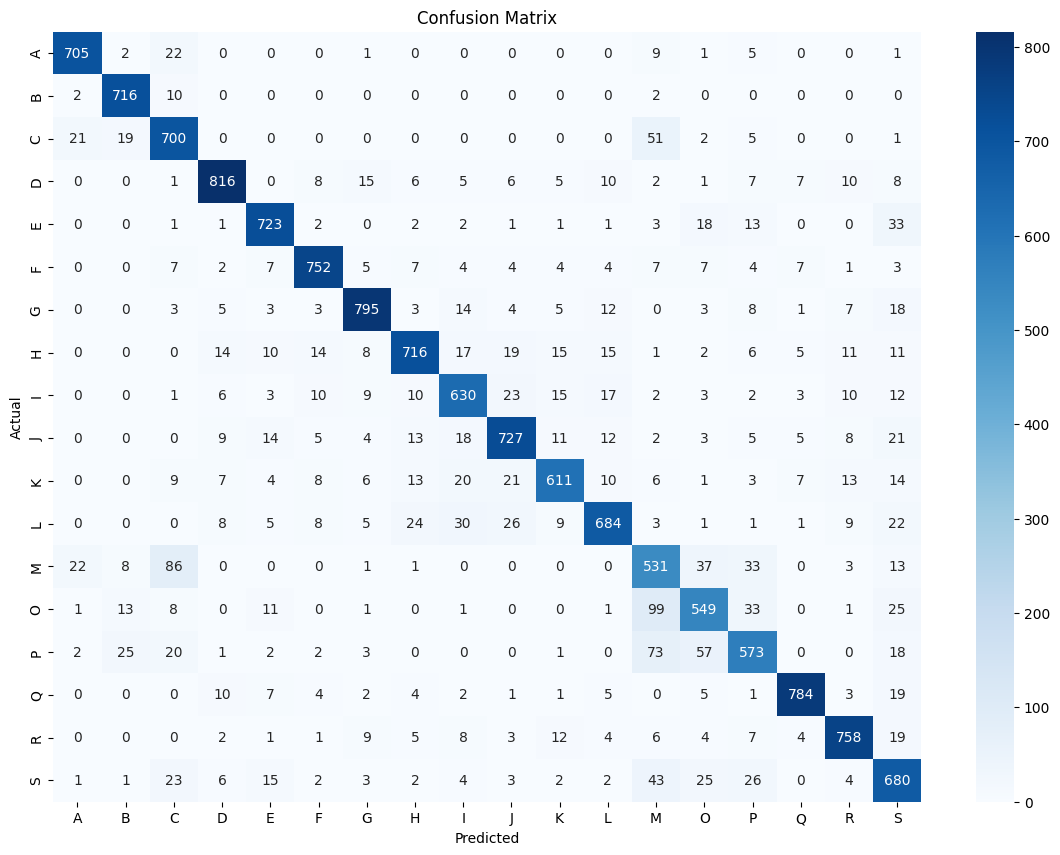

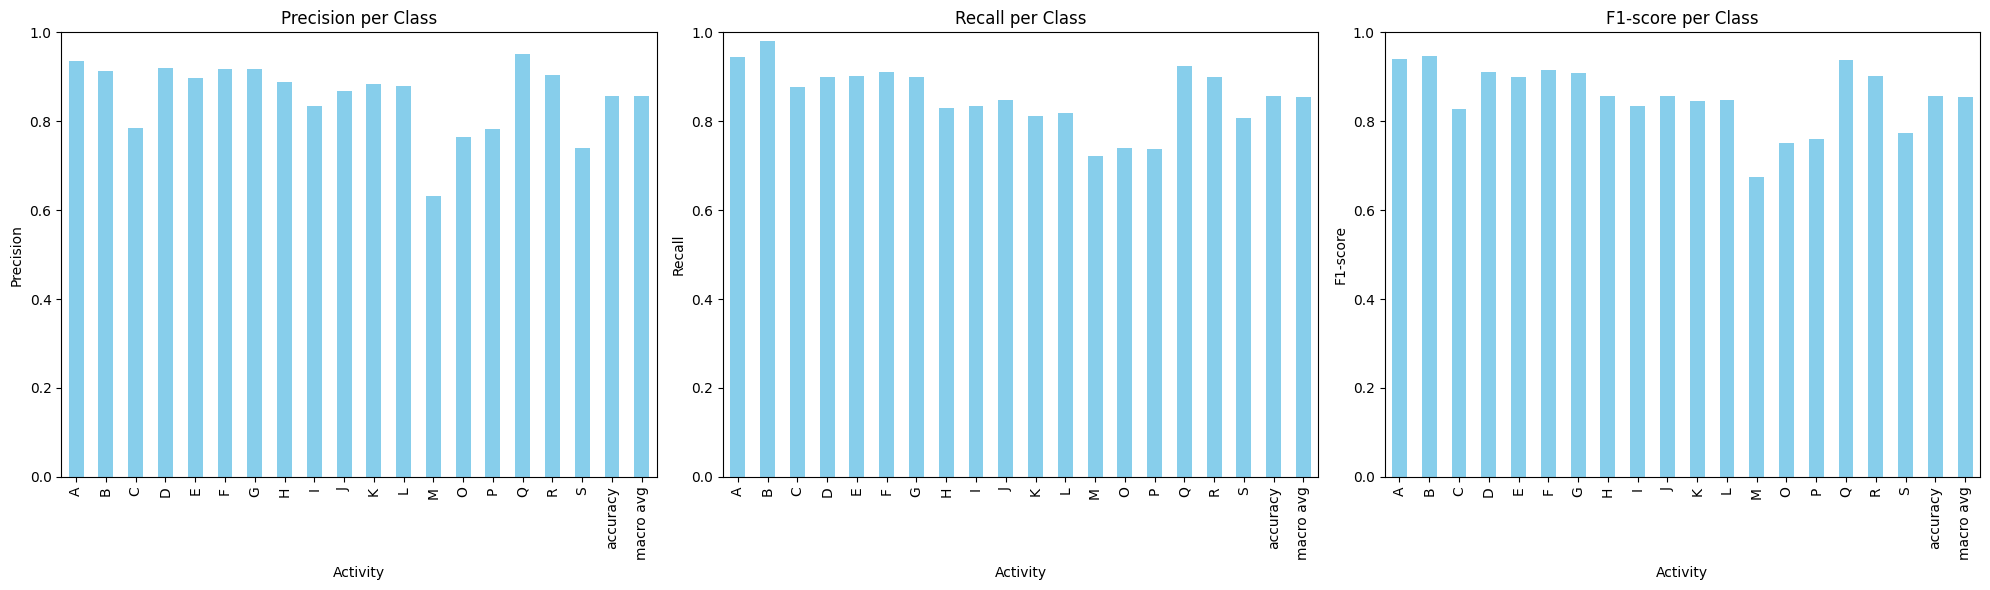

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
report_df = pd.DataFrame(class_report).transpose().iloc[:-1, :-1]
metrics = ['precision', 'recall', 'f1-score']
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

for i, metric in enumerate(metrics):
    report_df[metric].plot(kind='bar', ax=ax[i], color='skyblue')
    ax[i].set_title(f'{metric.capitalize()} per Class')
    ax[i].set_ylabel(metric.capitalize())
    ax[i].set_xlabel('Activity')
    ax[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()